In [1]:
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Specify path, experiment, file name
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'RCP85'
filename = 'sst.1.rcp85.remap.1950_2100.nc'
path = rootdir+experiment+'/'+filename

# Load file using xarray
ds = xr.open_dataset(path)

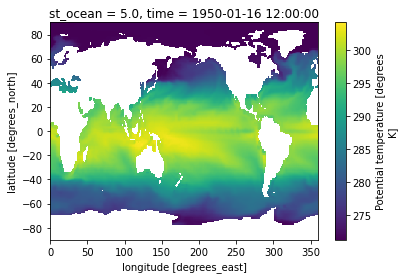

In [3]:
# Plot SST in January 1950
ds['temp'].isel(time=0).plot()

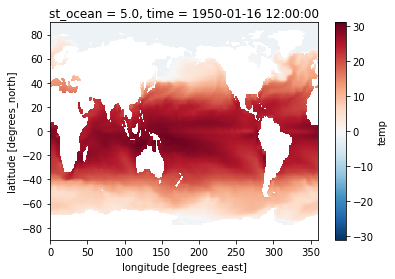

In [4]:
# Plot again, but in Celsius
(ds['temp']-273.15).isel(time=0).plot()

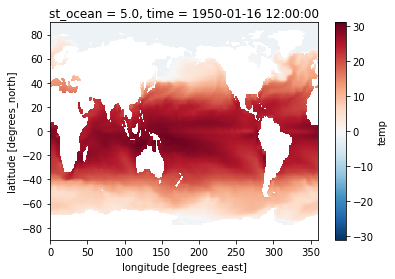

In [5]:
# Plot using .sel instead of .isel
(ds['temp']-273.15).sel(time='1950-01-16').plot()

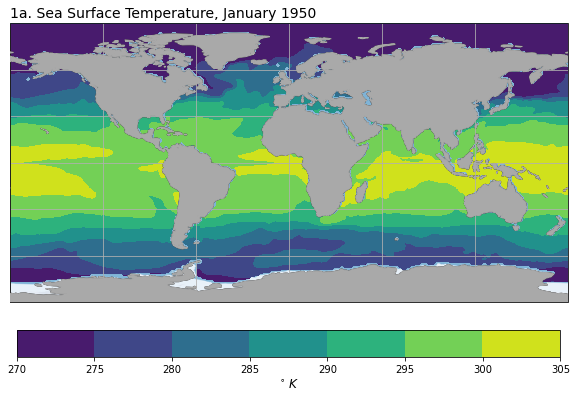

In [7]:
# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs})

# Specify variables
X = ds['xt_ocean']
Y = ds['yt_ocean']
Z = ds['temp'].sel(time='1950-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)

# Create contour plot of SST
im = ax.contourf(X,Y,Z,transform=crs)

# Add land mask, grid lines, coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()

# Set title and colorbar
ax.set_title('1a. Sea Surface Temperature, January 1950',fontsize=14,loc='left')
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)

Text(0.0, 1.0, '1b. Zoom in North Atlantic')

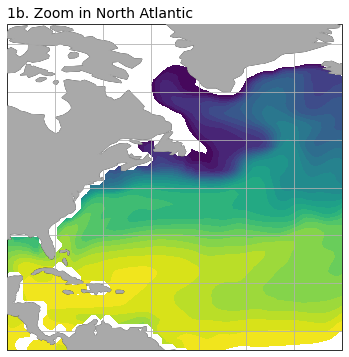

In [10]:
# Specify which contours to plot
clevs = np.arange(275,300,1)

# Create figure and axes
fig,ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':crs})

# Create contour plot of SST
im = ax.contourf(X,Y,Z,clevs,transform=crs)

# Zoom in on North Atlantic region
ax.set_extent([-90,-20,25,50])

# Add land mask, grid lines, coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()

# Adjust extent to ensure plot is square
ax.set_adjustable('datalim')

# Set title
ax.set_title('1b. Zoom in North Atlantic',fontsize=14,loc='left')

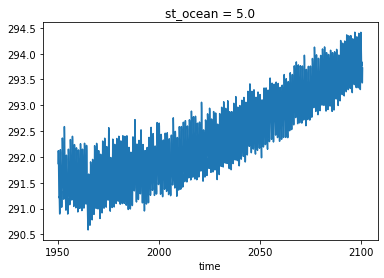

In [103]:
# Load area data
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':ds['xt_ocean'],'yt_ocean':ds['yt_ocean']})

# Calculate area-weighted mean SST
oceanmask = np.isfinite(ds['temp'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
temp_mean = (ds['temp']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))

# Plot mean SST
temp_mean.plot()

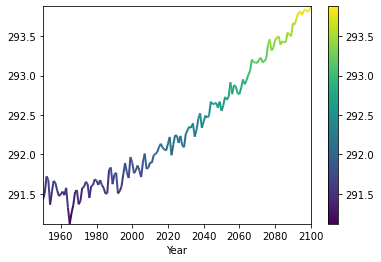

In [113]:
# Get year and mean SST data
x = np.unique(temp_mean['time.year'])
y = temp_mean.groupby('time.year').mean().squeeze()

# Create a set of line segments to color individually
points = np.array([x,y]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]], axis=1)

# Create figure and axes
fig, ax = plt.subplots()

# Create a continuous norm to map SST data to colors
norm = plt.Normalize(y.min(),y.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Use SST values for colormapping
lc.set_array(y)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

# Plot colored mean SST
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_xlabel('Year')
plt.show()

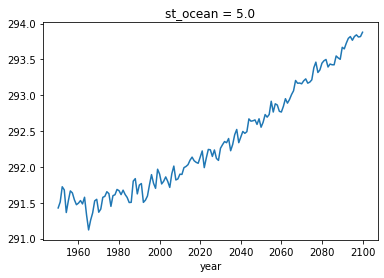

In [106]:
# Plot annual mean
temp_mean.groupby('time.year').mean().plot()

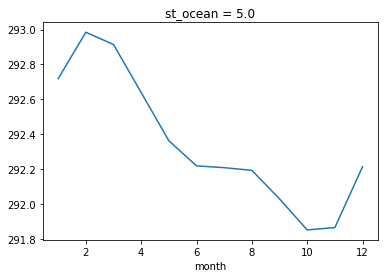

In [107]:
# Plot monthly climatology
temp_mean.groupby('time.month').mean().plot()

Text(0.5, 0, 'Month')

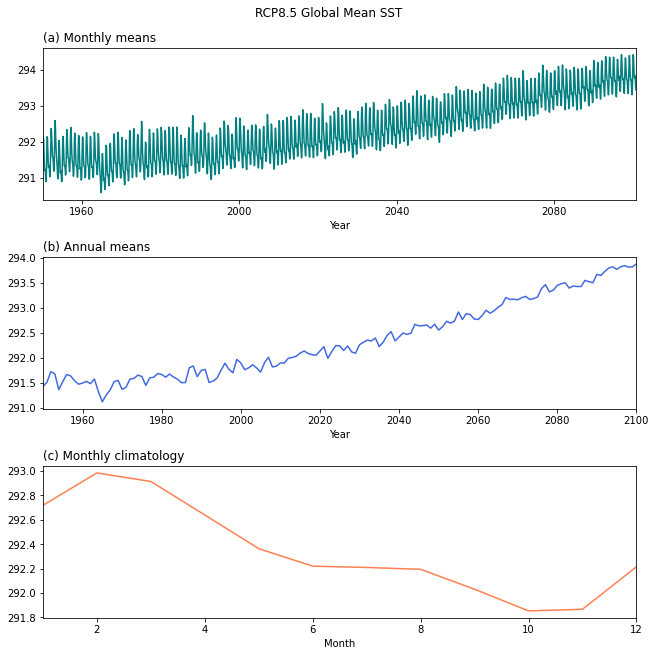

In [114]:
# Create figure, axes, title
fig, (ax0,ax1,ax2) = plt.subplots(figsize=(9,9),nrows=3,constrained_layout=True)
fig.suptitle('RCP8.5 Global Mean SST')

# Plot monthly means
ax0.plot(temp_mean['time'],temp_mean,color='teal')
ax0.set_title('(a) Monthly means',loc='left')
ax0.autoscale(enable=True,axis='x',tight=True)
ax0.set_xlabel('Year')

# Plot annual means
ax1.plot(np.unique(temp_mean['time.year']),temp_mean.groupby('time.year').mean(),color='royalblue')
ax1.set_title('(b) Annual means',loc='left')
ax1.autoscale(enable=True,axis='x',tight=True)
ax1.set_xlabel('Year')

# Plot monthly climatology
ax2.plot(np.unique(temp_mean['time.month']),temp_mean.groupby('time.month').mean(),color='coral')
ax2.set_title('(c) Monthly climatology',loc='left')
ax2.autoscale(enable=True,axis='x',tight=True)
ax2.set_xlabel('Month')